In [1]:
import torch
import matplotlib.pyplot as plt
import pickle
import numpy as np
import itertools

from torch.utils.data import DataLoader

import src.preprocess
import src.utils

from src.models import RNN, TransformerEncoderModel
from src.dataset import pad_collate_train, pad_collate_test
from src.eval import generate_test_output, spearman_score, group_spearman_score
from src.config import *

In [2]:
# get device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# Load Data

In [3]:
with open("output/1-layer/tf_train_group_datasets.pkl", "rb") as f:
    train_group_datasets = pickle.load(f)
with open("output/1-layer/tf_val_group_datasets.pkl", "rb") as f:
    val_group_datasets = pickle.load(f)

In [4]:
train_group_loaders = []
val_group_loaders = []

for dataset in train_group_datasets:
    data_loader = DataLoader(dataset=dataset,
                             batch_size=len(dataset),
                             shuffle=False,
                             collate_fn=src.dataset.pad_collate_train)
    train_group_loaders.append(data_loader)   

for dataset in val_group_datasets:
    data_loader = DataLoader(dataset=dataset,
                             batch_size=len(dataset),
                             shuffle=False,
                             collate_fn=src.dataset.pad_collate_train)
    val_group_loaders.append(data_loader)

In [5]:
model = TransformerEncoderModel(nlayers=1).to(device)
model.load_state_dict(torch.load("models/1-layer/transformer.ckpt"));

In [6]:
train_scores = np.array([spearman_score(loader, model, device) for loader in train_group_loaders])
val_scores = np.array([spearman_score(loader, model, device) for loader in val_group_loaders])

/home/calvin/anaconda3/envs/cs284a/lib/python3.7/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


We plot the histograms to visualize the group spearman score distributions for train and validationd datasets.

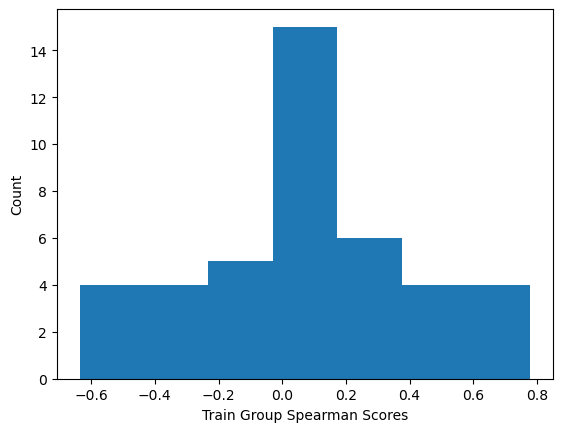

In [7]:
plt.hist(train_scores, bins='auto')
plt.xlabel("Train Group Spearman Scores")
plt.ylabel("Count");

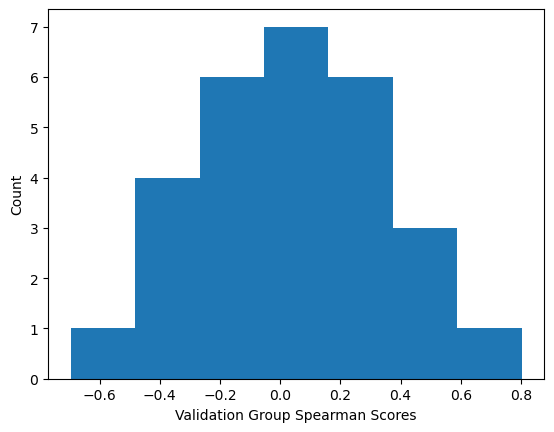

In [8]:
plt.hist(val_scores, bins='auto')
plt.xlabel("Validation Group Spearman Scores")
plt.ylabel("Count");

In [9]:
val_scores

array([-0.13120432,  0.05821926,  0.19598812, -0.45454545,  0.25433367,
       -0.29541958, -0.12727273,  0.42625431,  0.04769202,  0.42857143,
       -0.34064982,  0.27831442,  0.15694613, -0.69572524,  0.05084167,
        0.23558237,  0.20240789, -0.09719339, -0.22273584,  0.06348483,
        0.34068574, -0.0921298 ,  0.80193244, -0.39298488, -0.10604193,
        0.        ,  0.39393939, -0.03167752])

In [10]:
np.argmin(np.abs(val_scores)), np.argmax(val_scores)

(25, 22)

In [11]:
def get_tms(model, idx):
    y_pred_list = []
    y_target_list = []

    model.eval()
    with torch.no_grad():
        for _, X, y, ph in val_group_loaders[idx]:
            X = X.to(device)
            y = y.to(device)
            ph = ph.to(device)
            output = model(X, ph)

            y_pred_list.append(output.reshape(-1).detach().cpu().numpy())
            y_target_list.append(y.reshape(-1).detach().cpu().numpy())

    y_pred_list = [a.tolist() for a in y_pred_list]
    y_target_list = [a.tolist() for a in y_target_list]
    y_pred = np.array(list(itertools.chain.from_iterable(y_pred_list)))
    y_target = np.array(list(itertools.chain.from_iterable(y_target_list)))
    
    return y_pred_list, y_target_list

In [12]:
y_pred_list, y_target_list = get_tms(model, 25)

In [13]:
y_pred_list

[[50.52349090576172,
  50.51292037963867,
  50.49740982055664,
  50.928653717041016,
  50.41400909423828]]

In [14]:
y_target_list

[[56.400001525878906,
  55.900001525878906,
  54.5,
  53.20000076293945,
  54.400001525878906]]

For a score of zero, the ordering does not match the target at all.

In [15]:
y_pred_list, y_target_list = get_tms(model, 22)

In [16]:
y_pred_list

[[60.41340255737305,
  60.35982131958008,
  60.52293395996094,
  60.62734603881836,
  60.62734603881836,
  60.44569396972656,
  60.76011657714844,
  59.97941970825195,
  60.249298095703125,
  59.974308013916016,
  60.75960159301758,
  60.75960159301758,
  60.71532440185547,
  60.228721618652344,
  60.357975006103516,
  60.69663619995117,
  59.97254180908203,
  60.18730163574219,
  60.08539581298828]]

In [17]:
y_target_list

[[57.29999923706055,
  58.79999923706055,
  60.5,
  60.29999923706055,
  72.9000015258789,
  59.29999923706055,
  72.19999694824219,
  57.70000076293945,
  58.599998474121094,
  58.70000076293945,
  62.400001525878906,
  74.0999984741211,
  59.79999923706055,
  57.5,
  58.20000076293945,
  59.599998474121094,
  57.400001525878906,
  59.0,
  58.70000076293945]]

For a high score, the model outputs Tm values that follow the target order more closely.